# GERMAN CREDIT MODELING

- Decision Tree
- Gradient Boosting
- Random Forest
- Neural Net
- Logistic Regression

Continues EDA work from separate notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('germancredit.csv',header=0)

In [3]:
# Metadata
md = pd.read_csv('GermanCreditMetaData.csv',header=0,index_col='Code')
md['Ord Meaning'] = md.index + ' ' + md.Meaning
mdmap = md['Ord Meaning'].to_dict()

## Data Transformations

In [4]:
df['bad'] = df.pop('GoodCredit') - 1

# New Feature: Age Group (Nominal)
df['age_group'] =  pd.cut(df.age13,[18,25,30,50,60,90])

In [5]:
v_nominal = list(df.select_dtypes(include='O').columns)
nominal = v_nominal + ['age_group'] + ['installment8','residence11','liable18']

baseline_level = ['checkingstatus1_A14', 'history3_A32', 'purpose4_A49', 
                  'savings6_A65', 'employ7_A75', 
                  'status9_A92', 'others10_A101', 'property12_A124', 
                  'otherplans14_A143', 'housing15_A152', 
                  'job17_A173', 'tele19_A191', 'foreign20_A201', 
                  'age_group_(60, 90]', 'installment8_4', 
                  'residence11_4', 'liable18_1']
df = pd.get_dummies(df, columns=nominal).drop(baseline_level,axis=1)
df.shape

(1000, 57)

In [6]:
predictors = df.drop('bad',axis=1).columns
print(*sorted(predictors),sep='\t')

age13	age_group_(18, 25]	age_group_(25, 30]	age_group_(30, 50]	age_group_(50, 60]	amount5	cards16	checkingstatus1_A11	checkingstatus1_A12	checkingstatus1_A13	duration2	employ7_A71	employ7_A72	employ7_A73	employ7_A74	foreign20_A202	history3_A30	history3_A31	history3_A33	history3_A34	housing15_A151	housing15_A153	installment8_1	installment8_2	installment8_3	job17_A171	job17_A172	job17_A174	liable18_2	otherplans14_A141	otherplans14_A142	others10_A102	others10_A103	property12_A121	property12_A122	property12_A123	purpose4_A40	purpose4_A41	purpose4_A410	purpose4_A42	purpose4_A43	purpose4_A44	purpose4_A45	purpose4_A46	purpose4_A48	residence11_1	residence11_2	residence11_3	savings6_A61	savings6_A62	savings6_A63	savings6_A64	status9_A91	status9_A93	status9_A94	tele19_A192


In [7]:
from sklearn.preprocessing import StandardScaler

np.random.seed(2018)
rng = np.random.sample(len(df))

X_train = df.loc[rng < 0.6, predictors]
y_train = df.loc[rng < 0.6, 'bad']
X_test  = df.loc[rng >= 0.6, predictors]
y_test  = df.loc[rng >= 0.6, 'bad']

scaler = StandardScaler()
scaler.fit(X_train.values.astype('float'))

X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# Combine

X_std = scaler.transform(df[predictors])
y     = df.bad.values

## Decision Tree Classifier

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report

dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30,
                           min_impurity_decrease=.0001,
                           random_state=18, class_weight={1:1.0,0:0.1})
dt.fit(X_train, y_train)

print(classification_report(y_test,dt.predict(X_test)))
y_pred_dt = dt.predict_proba(X_test)[:, 1]
y_est_dt  = dt.predict_proba(X_train)[:, 1]

print('DTree Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_dt),
    roc_auc_score(y_test, y_pred_dt)))

             precision    recall  f1-score   support

          0       0.89      0.20      0.32       298
          1       0.31      0.94      0.47       116

avg / total       0.73      0.41      0.36       414

DTree Training AUC = 76.34%       Validation AUC = 74.82%


Predictors in Model 7

Feature Imporances (Top Predictors)


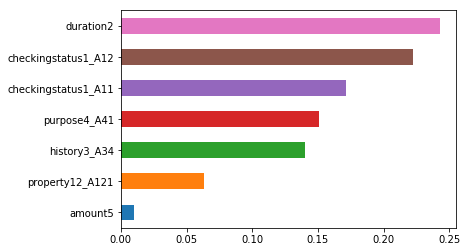

In [9]:
fi = pd.Series(dt.feature_importances_,index=predictors)
fi = fi[fi>0]
print('Predictors in Model',len(fi))
print('\nFeature Imporances (Top Predictors)')
_ = fi.sort_values().plot.barh()

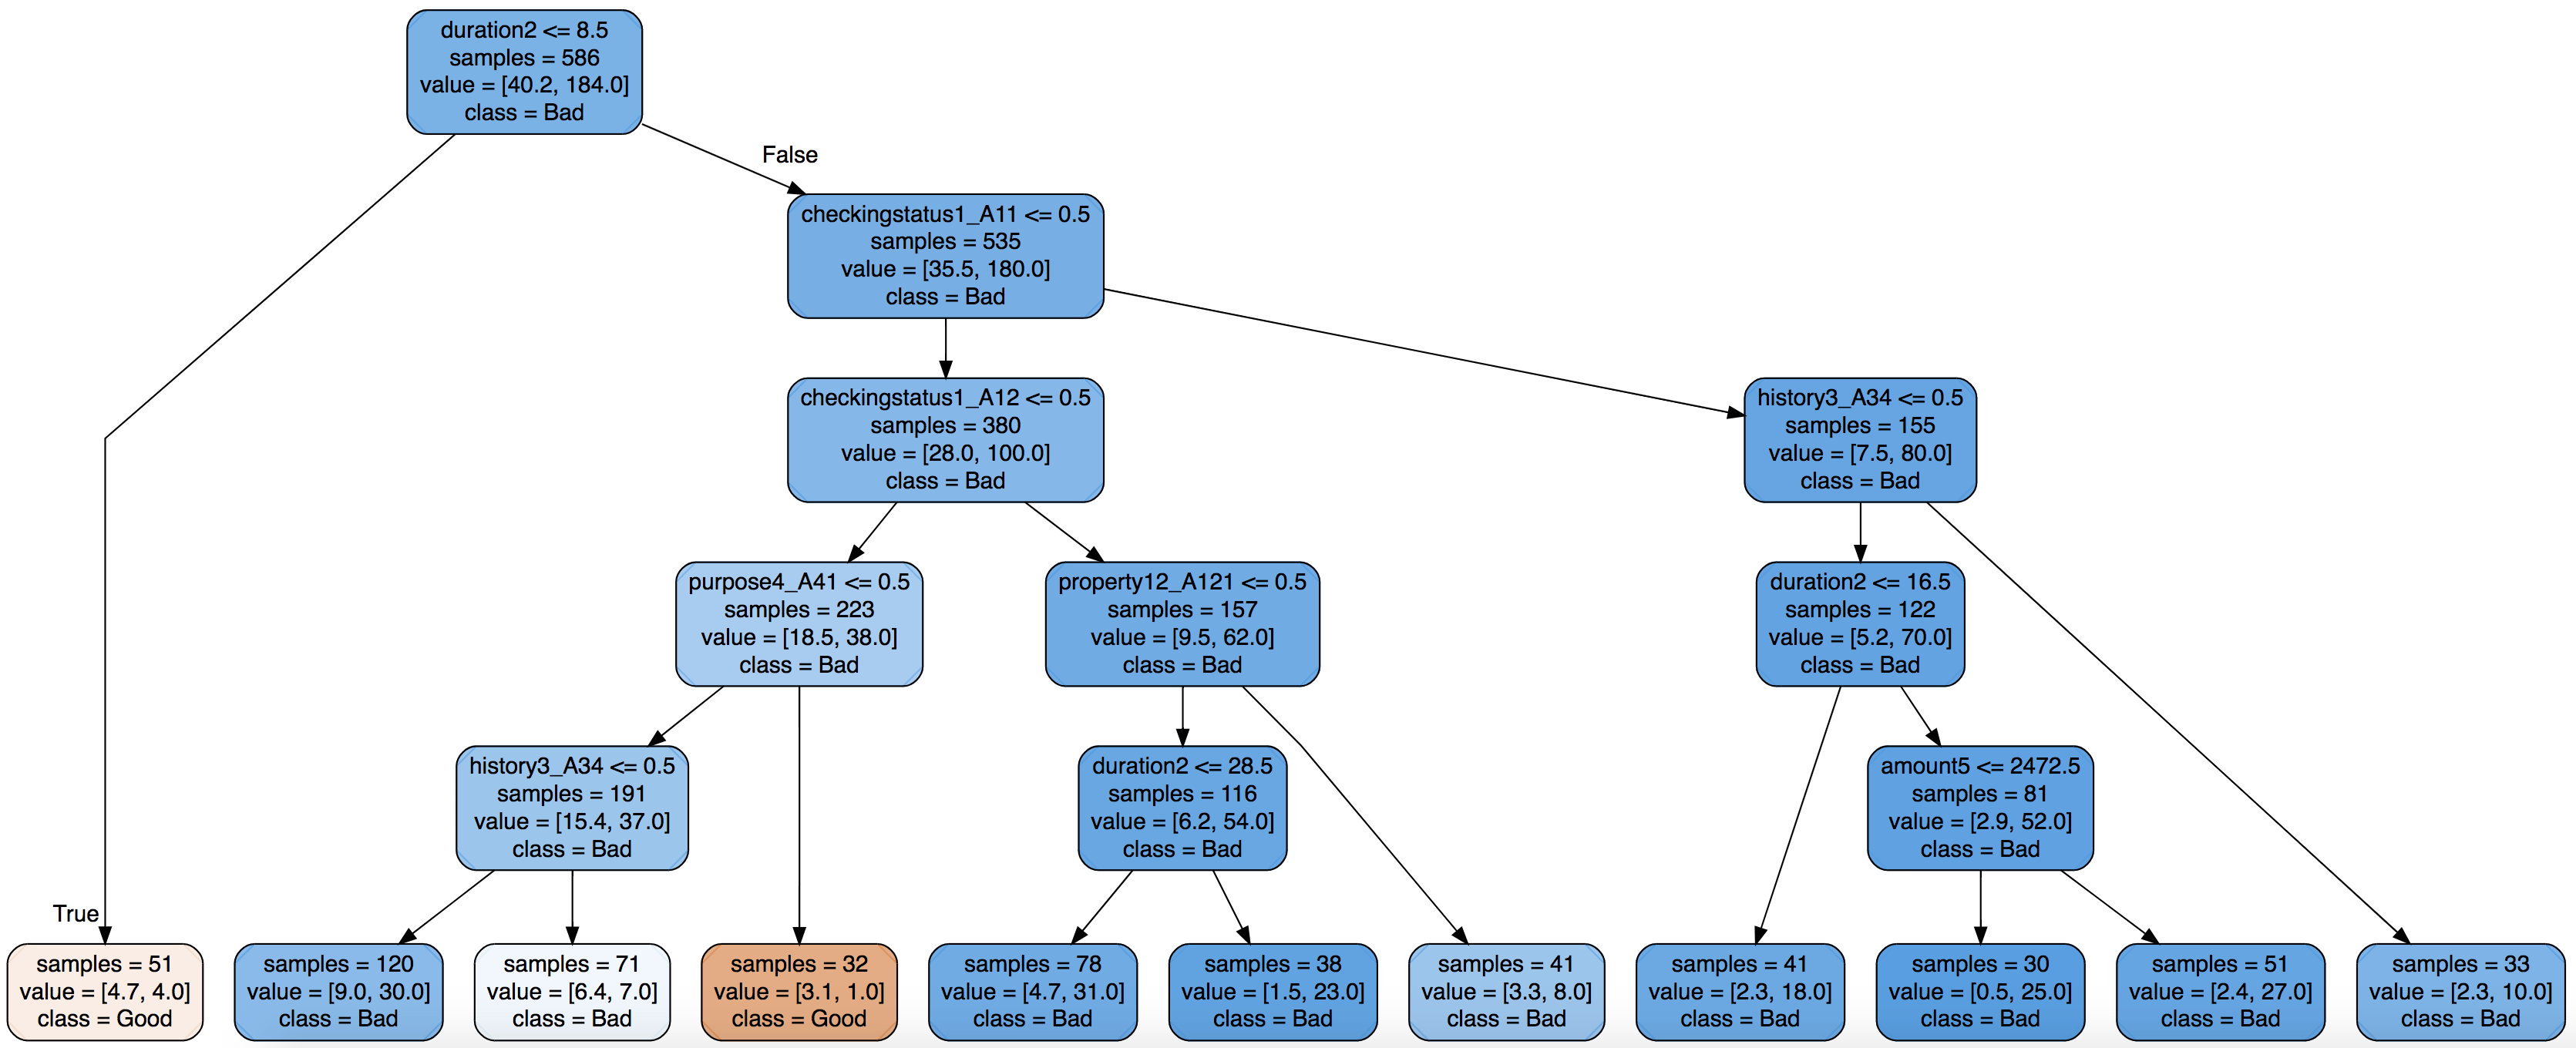

In [10]:
from sklearn.tree import export_graphviz
from IPython.display import Image

tree_graph = export_graphviz(dt,out_file=None,                              
    impurity = False,
    leaves_parallel=True,
    feature_names = predictors,
    class_names = ['Good', 'Bad'],
    rounded = True,
    filled= True )
#print(tree_graph)
Image("GermanCreditDTree.png")

In [11]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature ]

    def recurse(node, depth, index):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}{}) {} <= {} n={} {}".format(indent, index, name, threshold,
                tree_.n_node_samples[node],
                tree_.value[node] / tree_.weighted_n_node_samples[node]))
            recurse(tree_.children_left[node], depth + 1, 2*index+1)
            recurse(tree_.children_right[node], depth + 1, 2*index+2)
        else:
            print("{}{}) n={} {} *".format(indent, index, tree_.n_node_samples[node],
                 tree_.value[node] / tree_.weighted_n_node_samples[node]))

    recurse(0, 0, 0)

## Gradient Boosting Tree

In [12]:
tree_to_code(dt,predictors)

0) duration2 <= 8.5 n=586 [[ 0.17930419  0.82069581]]
    1) n=51 [[ 0.54022989  0.45977011]] *
    2) checkingstatus1_A11 <= 0.5 n=535 [[ 0.16473318  0.83526682]]
        5) checkingstatus1_A12 <= 0.5 n=380 [[ 0.21875  0.78125]]
            11) purpose4_A41 <= 0.5 n=223 [[ 0.32743363  0.67256637]]
                23) history3_A34 <= 0.5 n=191 [[ 0.29389313  0.70610687]]
                    47) n=120 [[ 0.23076923  0.76923077]] *
                    48) n=71 [[ 0.47761194  0.52238806]] *
                24) n=32 [[ 0.75609756  0.24390244]] *
            12) property12_A121 <= 0.5 n=157 [[ 0.13286713  0.86713287]]
                25) duration2 <= 28.5 n=116 [[ 0.10299003  0.89700997]]
                    51) n=78 [[ 0.13165266  0.86834734]] *
                    52) n=38 [[ 0.06122449  0.93877551]] *
                26) n=41 [[ 0.2920354  0.7079646]] *
        6) history3_A34 <= 0.5 n=155 [[ 0.08571429  0.91428571]]
            13) duration2 <= 16.5 n=122 [[ 0.06914894  0.93085106]]
   

### Non Trivial Stump

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

grd = GradientBoostingClassifier(max_leaf_nodes=8,learning_rate=0.001,
            n_estimators=3000,subsample=.5, min_samples_leaf=10,
                                 random_state=18)
grd.fit(X_train, y_train)

y_pred_grd = grd.predict_proba(X_test)[:, 1]
y_est_grd  = grd.predict_proba(X_train)[:, 1]

print('GBM Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_grd),
    roc_auc_score(y_test, y_pred_grd)))

GBM Training AUC = 91.83%       Validation AUC = 82.04%


Predictors in Model 52

Feature Imporances (Top Predictors)


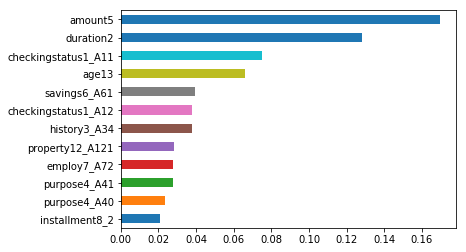

In [14]:
fi = pd.Series(grd.feature_importances_,index=predictors)
fi = fi[fi>0]
print('Predictors in Model',len(fi))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.02].sort_values().plot.barh()

### Trivial Stump

In [15]:
from sklearn.ensemble import AdaBoostClassifier

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=10)
#dt_stump.fit(X_train_std, y_train)

ada = AdaBoostClassifier(base_estimator=dt_stump,n_estimators=1000,
                         algorithm="SAMME",random_state=18)

ada.fit(X_train, y_train)

y_pred_ada = ada.predict_proba(X_test)[:, 1]
y_est_ada  = ada.predict_proba(X_train)[:, 1]

print('ADA   Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_ada),
    roc_auc_score(y_test, y_pred_ada)))

ADA   Training AUC = 84.65%       Validation AUC = 77.31%


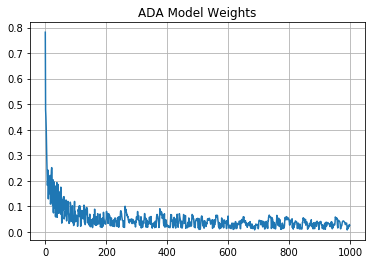

In [16]:
plt.plot(ada.estimator_weights_)
plt.grid()
_ = plt.title('ADA Model Weights')

Predictors in Model 45

Feature Imporances (Top Predictors)


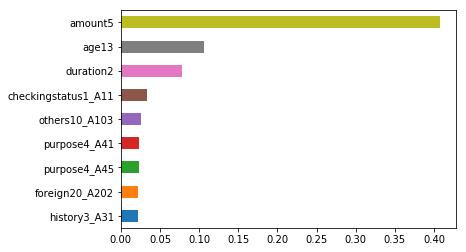

In [17]:
fi = pd.Series(ada.feature_importances_,index=predictors)
fi = fi[fi>0]
print('Predictors in Model',len(fi))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.02].sort_values().plot.barh()

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,max_depth=9,min_samples_leaf=10,
                           random_state=18,
                           min_impurity_decrease=.0000001)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_est_rf  = rf.predict_proba(X_train)[:, 1]

print('Random Forest Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_rf),
    roc_auc_score(y_test, y_pred_rf)))

Random Forest Training AUC = 90.11%       Validation AUC = 81.50%


Predictors in Model 52

Feature Imporances (Top Predictors)


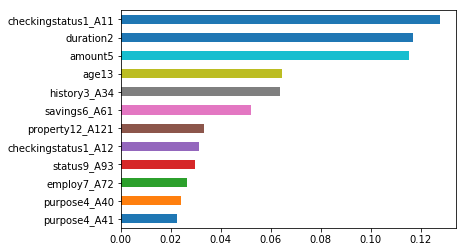

In [19]:
fi = pd.Series(rf.feature_importances_,index=predictors)
fi = fi[fi>0.0]
print('Predictors in Model',len(fi))
print('\nFeature Imporances (Top Predictors)')
_ = fi[fi>0.02].sort_values().plot.barh()

## Neural Network (sklearn)

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits)

nnet_model = []
y_est  = []
y_pred = []

res = pd.DataFrame(index=np.arange(len(X_std)),
                  columns=['pred'] + ['est_{}'.format(i) for i in range(n_splits)])


fold = 0
for train_i_, test_i_ in skf.split(X_std,y):
    X_tr, y_tr = X_std[train_i_], y[train_i_]
    X_of, y_of = X_std[test_i_],  y[test_i_]
    
    
    nnet = MLPClassifier(solver='adam', 
                         alpha=0.02, 
                         max_iter = 5000,
                         learning_rate_init=.001,
                         hidden_layer_sizes=(10,),
                         batch_size=200,
                         tol=1e-3,
                         random_state=18)

    nnet.fit(X_tr, y_tr)

    y_est_nnet  = nnet.predict_proba(X_tr)[:, 1]
    y_pred_nnet = nnet.predict_proba(X_of)[:, 1]
    
    y_all_nnet  = nnet.predict_proba(X_std)[:, 1]
    res.iloc[train_i_,fold+1] = y_est_nnet
    res.iloc[test_i_,0] = y_pred_nnet
    
    print('Neural Network Train AUC = {:.2%} Valid AUC = {:.2%} All AUC = {:.2%}'.format(
        roc_auc_score(y_tr, y_est_nnet),
        roc_auc_score(y_of, y_pred_nnet),
        roc_auc_score(y,    y_all_nnet)
        ))
    
    nnet_model.append((roc_auc_score(y_of, y_pred_nnet),nnet))
    fold += 1
    
nnet_roc_auc, nnet = max(nnet_model)

Neural Network Train AUC = 94.79% Valid AUC = 78.90% All AUC = 93.03%
Neural Network Train AUC = 92.84% Valid AUC = 76.33% All AUC = 91.32%
Neural Network Train AUC = 94.74% Valid AUC = 77.48% All AUC = 92.86%
Neural Network Train AUC = 94.18% Valid AUC = 77.24% All AUC = 92.50%
Neural Network Train AUC = 94.54% Valid AUC = 78.71% All AUC = 93.04%
Neural Network Train AUC = 93.94% Valid AUC = 78.95% All AUC = 92.38%
Neural Network Train AUC = 92.86% Valid AUC = 70.67% All AUC = 91.10%
Neural Network Train AUC = 94.57% Valid AUC = 80.76% All AUC = 93.09%
Neural Network Train AUC = 92.25% Valid AUC = 79.76% All AUC = 90.99%
Neural Network Train AUC = 95.02% Valid AUC = 75.00% All AUC = 93.03%


In [21]:
y_est_nnet  = res.drop('pred',axis=1).mean(axis=1)[y_train.index]
y_pred_nnet = res.iloc[y_test.index,0]

nnet_roc_auc, nnet

(0.80761904761904757,
 MLPClassifier(activation='relu', alpha=0.02, batch_size=200, beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(10,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=5000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=18, shuffle=True,
        solver='adam', tol=0.001, validation_fraction=0.1, verbose=False,
        warm_start=False))

Stacked Models Score 80.31%




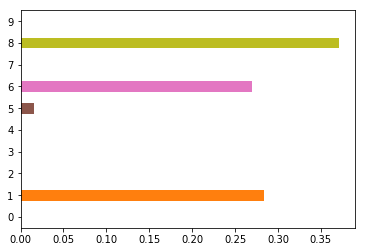

In [22]:
from sklearn.linear_model import LassoCV

stack = LassoCV(normalize=True,positive=True,fit_intercept=False)

X_stack = np.array([m.predict_proba(X_std)[:, 1] for f,m in nnet_model]).T
stack.fit(X_stack,res['pred'])

pd.Series(stack.coef_).plot.barh()
print('Stacked Models Score {:.2%}\n\n'.format(stack.score(X_stack,res['pred'])))

In [23]:
stack_est = stack.predict(X_stack)
y_est_nnet  = stack_est[y_train.index]
y_pred_nnet = stack_est[y_test.index]

## Logistic Regression

### Logistic Regression: As if Machine Learning
#### Optimizing Penalty Type and Regularization Parameter

In [24]:
from sklearn.linear_model import LogisticRegression


# Set regularization parameter
for i, C in enumerate((10,1, 0.05, .01, .001)):
    # turn down tolerance for short training time
    print('C ',C)
    clf_l1_LR = LogisticRegression(C=C, penalty='l1')
    clf_l2_LR = LogisticRegression(C=C, penalty='l2')
    clf_l1_LR.fit(X_train_std, y_train)
    clf_l2_LR.fit(X_train_std, y_train)

    y_est_logit_l1  = clf_l1_LR.predict_proba(X_train_std)[:, 1]
    y_pred_logit_l1 = clf_l1_LR.predict_proba(X_test_std)[:, 1]
    print('LOGIT L1 Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
        roc_auc_score(y_train, y_est_logit_l1),
        roc_auc_score(y_test, y_pred_logit_l1)))

    y_est_logit_l2  = clf_l2_LR.predict_proba(X_train_std)[:, 1]
    y_pred_logit_l2 = clf_l2_LR.predict_proba(X_test_std)[:, 1]
    print('LOGIT L2 Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
        roc_auc_score(y_train, y_est_logit_l2),
        roc_auc_score(y_test, y_pred_logit_l2)))

C  10
LOGIT L1 Training AUC = 85.29%       Validation AUC = 78.39%
LOGIT L2 Training AUC = 85.28%       Validation AUC = 78.34%
C  1
LOGIT L1 Training AUC = 85.25%       Validation AUC = 78.87%
LOGIT L2 Training AUC = 85.28%       Validation AUC = 78.49%
C  0.05
LOGIT L1 Training AUC = 79.69%       Validation AUC = 78.90%
LOGIT L2 Training AUC = 85.05%       Validation AUC = 78.91%
C  0.01
LOGIT L1 Training AUC = 50.00%       Validation AUC = 50.00%
LOGIT L2 Training AUC = 84.15%       Validation AUC = 79.17%
C  0.001
LOGIT L1 Training AUC = 50.00%       Validation AUC = 50.00%
LOGIT L2 Training AUC = 82.25%       Validation AUC = 79.30%


#### Using LogisticRegressionCV

In [25]:
from sklearn.linear_model import LogisticRegressionCV

lrcv = LogisticRegressionCV()

lrcv.fit(X_std,y)

y_est_lrcv  = lrcv.predict_proba(X_train_std)[:, 1]
y_pred_lrcv = lrcv.predict_proba(X_test_std)[:, 1]
print('LOGIT CV Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
    roc_auc_score(y_train, y_est_lrcv),
    roc_auc_score(y_test, y_pred_lrcv)))

LOGIT CV Training AUC = 83.82%       Validation AUC = 83.72%


Predictors in Model (56/56)

Log Reg CV Coefficients


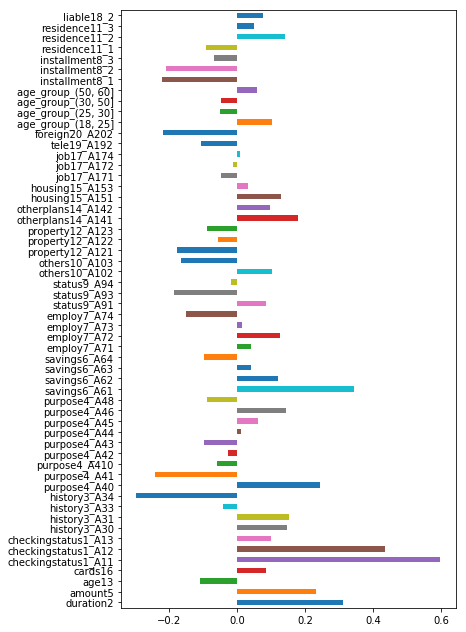

In [26]:
coef = pd.Series(lrcv.coef_.ravel(),index=predictors)

print('Predictors in Model ({}/{})'.format(len(coef),len(predictors)))
print('\nLog Reg CV Coefficients')

_ = coef.plot.barh(figsize=(6,11))

### Logistic Regression: Variables Selected According to Theory and Previous Practice

In [27]:
scvars = ['savings6', 'property12', 'amount5', 'checkingstatus1',' duration2', 'history3', 'purpose4']
scvars_select = [any(v in p for v in scvars) for p in predictors]

In [28]:
logreg = LogisticRegression(C=10)
X_train_lr = X_train_std[:,scvars_select]
X_test_lr  = X_test_std[:,scvars_select]

logreg.fit(X_train_lr,y_train)

y_est_prob  = logreg.predict_proba(X_train_lr)[:, 1]
y_pred_prob = logreg.predict_proba(X_test_lr)[:, 1]
print('LOGIT Training AUC = {:.2%}       Validation AUC = {:.2%}'.format(
        roc_auc_score(y_train, y_est_prob),
        roc_auc_score(y_test, y_pred_prob)))

LOGIT Training AUC = 79.52%       Validation AUC = 75.68%


In [29]:
predictors_lr = [p for p in predictors if any(v in p for v in scvars)]\

predictors_lr2 = []
pred = []
for p in predictors_lr:
    if '_' in p:
        f,s = p.split('_')
        predictors_lr2.append(mdmap[s])
        pred.append(f)
    else:
        predictors_lr2.append(p)
        pred.append(p)

In [30]:
coef = pd.Series(logreg.coef_.ravel(),index=predictors_lr2)

print('Predictors in Model ({}/{})'.format(len(coef),len(scvars)))
print('\nLog Reg Coefficients')

out = coef.rename('model coeff').to_frame()
out['Predictor'] = pred
out.style.bar(align='zero',color=['lightblue','red'])

Predictors in Model (24/7)

Log Reg Coefficients


## Perturbation Analysis

In [31]:
def prob2logit(p):
    return np.log((1-p)/p)

def perturb(model,X,pred,a0=0,a1=1):
    
    p_hat = model.predict_proba(X)[:,1]

    df = pd.DataFrame()

    # amount5
    
    amt_col = np.where([p=='amount5' for p in list(pred)])
    X0 = X.copy()
    X0[:,amt_col] = a0
    X1 = X0.copy()
    X1[:,amt_col] = a1
    
    p_hat_0 = model.predict_proba(X0)[:,1]
    p_hat_1 = model.predict_proba(X1)[:,1]
    
    diff = pd.DataFrame()
    diff['amount5'] = pd.Series(p_hat_0-p_hat_1).describe()
    
    df['amount5'] = np.apply_along_axis(prob2logit,0, p_hat_1) - np.apply_along_axis(prob2logit,0, p_hat_0)
    df['amount5_p0'] = p_hat_0
    df['amount5_p1'] = p_hat_1

    
    # checkingstatus1_A11
    
    cs1_col = np.where([p=='checkingstatus1_A11' for p in list(pred)])
    cs2_col = np.where([p=='checkingstatus1_A12' for p in list(pred)])
    cs3_col = np.where([p=='checkingstatus1_A13' for p in list(pred)])
        
    X0 = X.copy()
    X0[:,cs1_col] = X[:,cs1_col].min()
    X0[:,cs2_col] = X[:,cs2_col].max()
    X0[:,cs3_col] = X[:,cs3_col].min()
    
    X1 = X.copy()
    X1[:,cs1_col] = X[:,cs1_col].max()
    X1[:,cs2_col] = X[:,cs2_col].min()
    X1[:,cs3_col] = X[:,cs3_col].min()

    
    p_hat_0 = model.predict_proba(X0)[:,1]
    p_hat_1 = model.predict_proba(X1)[:,1]
    
    diff['checkingstatus1_A11'] = pd.Series(p_hat_0-p_hat_1).describe()
    display(diff.transpose().style.format('{:>.3f}').set_caption('Pre Post Score Difference'))

    df['checkingstatus1_A11'] = np.apply_along_axis(prob2logit,0, p_hat_1) - np.apply_along_axis(prob2logit,0, p_hat_0)
    df['checkingstatus1_A11_p0'] = p_hat_0
    df['checkingstatus1_A11_p1'] = p_hat_1

        
    df.index = p_hat
    df.index.name = str(model.__class__).split('.')[-1][:-2]
    print('Perturbation Analysis for model\n\n',model)
    return df

In [32]:
def perturb_summary(Z,var='amount5',pcutoff=90,prime=600):
    prob_cutoff = prob2logit(np.percentile(Z.index.values,pcutoff))
    W = Z[[var+'_p0',var+'_p1']].sort_values(by=var+'_p1').apply(prob2logit,axis=1)
    W = (W - prob_cutoff) * 250 / (W.values.max() - prob_cutoff) + prime
    plt.plot(W[var+'_p1'],W[var+'_p0'], 'bo', mfc='w')
    plt.title(Z.index.name)
    plt.grid()
    ax = plt.axvline(x=prime, color='g', linestyle=':')
    plt.plot(W[var+'_p1'],W[var+'_p1'],ls='-.',c='grey')
    plt.xlabel('Credit Score Pre')
    plt.ylabel('Credit Score Post')
    ax = plt.axhline(y=prime, xmax=prime, color='r', linestyle=':')
    plt.legend((var,'cutoff pre','ident','cutoff post'))

Perturbation Analysis for model

 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
amount5               -0.294610
checkingstatus1_A11   -0.427623
dtype: float64


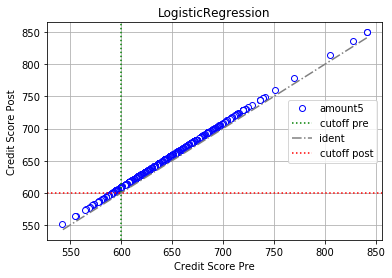

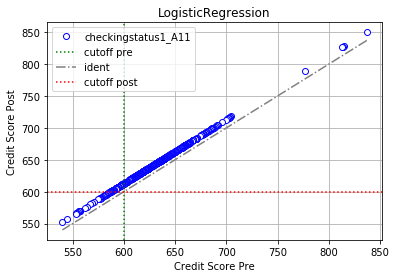

In [33]:
Z = perturb(logreg,X_train_lr,predictors_lr)
print(Z[['amount5','checkingstatus1_A11']].mean())
perturb_summary(Z,var='amount5')
plt.show()
perturb_summary(Z,var='checkingstatus1_A11')
plt.show()

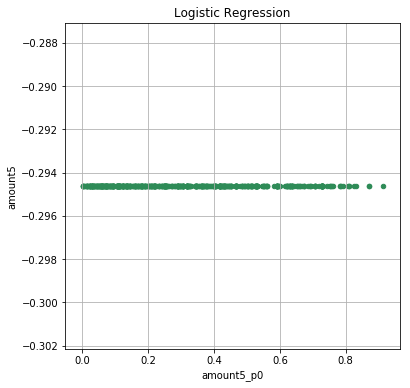

In [34]:
_ = Z.plot.scatter(x='amount5_p0',y='amount5',title='Logistic Regression',
                    figsize=(6,6),grid=True,color='seagreen')

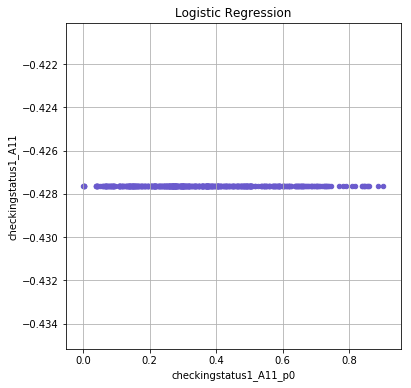

In [35]:
_ = Z.plot.scatter(x='checkingstatus1_A11_p0',y='checkingstatus1_A11',
                   title='Logistic Regression',
                   figsize=(6,6),grid=True,color='slateblue')

Perturbation Analysis for model

 AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=1000, random_state=18)
amount5               -0.000977
checkingstatus1_A11   -0.010488
dtype: float64


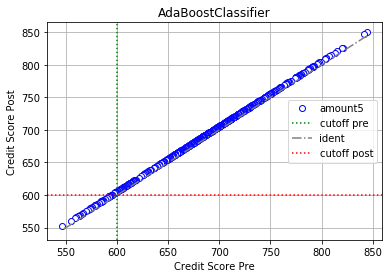

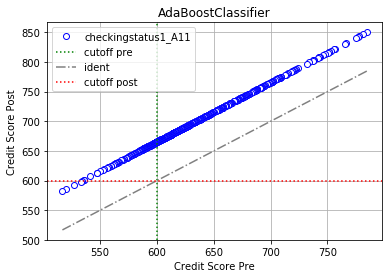

In [36]:
Z = perturb(ada,X_train.values,predictors,a0=3200.,a1=6000.)
print(Z[['amount5','checkingstatus1_A11']].mean())
perturb_summary(Z,var='amount5')
plt.show()
perturb_summary(Z,var='checkingstatus1_A11')
plt.show()

Perturbation Analysis for model

 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.001, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=8,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=3000,
              presort='auto', random_state=18, subsample=0.5, verbose=0,
              warm_start=False)
amount5               -0.255909
checkingstatus1_A11   -0.424641
dtype: float64


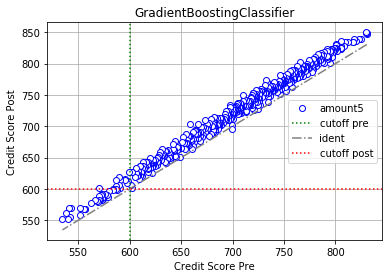

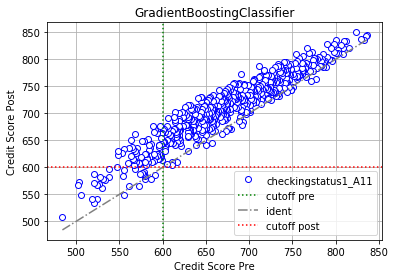

In [37]:
Z = perturb(grd,X_train.values,predictors,a0=3200.,a1=6000.)
print(Z[['amount5','checkingstatus1_A11']].mean())
perturb_summary(Z,var='amount5')
plt.show()
perturb_summary(Z,var='checkingstatus1_A11')
plt.show()

Perturbation Analysis for model

 DecisionTreeClassifier(class_weight={1: 1.0, 0: 0.1}, criterion='gini',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0001, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=18,
            splitter='best')
amount5                0.000000
checkingstatus1_A11   -0.474602
dtype: float64


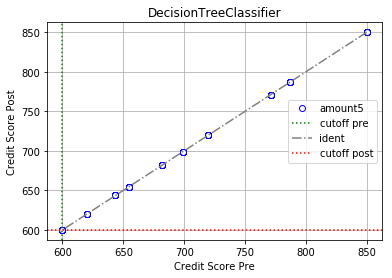

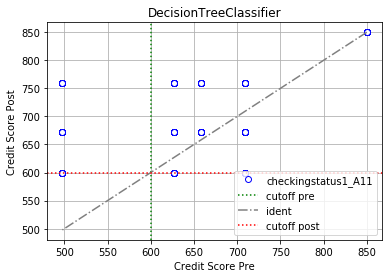

In [38]:
Z = perturb(dt,X_train.values,predictors,a0=3200.,a1=6000.)
print(Z[['amount5','checkingstatus1_A11']].mean())
perturb_summary(Z,var='amount5')
plt.show()
perturb_summary(Z,var='checkingstatus1_A11')
plt.show()

Perturbation Analysis for model

 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=18, verbose=0, warm_start=False)
amount5               -0.15344
checkingstatus1_A11   -0.37287
dtype: float64


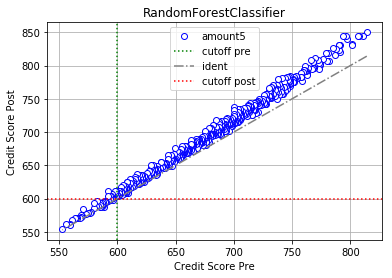

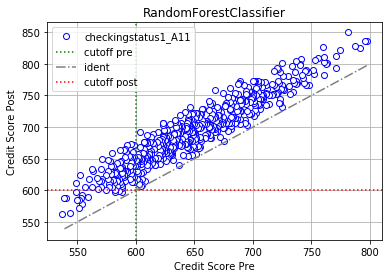

In [39]:
Z = perturb(rf,X_train.values,predictors,a0=3200.,a1=6000.)
print(Z[['amount5','checkingstatus1_A11']].mean())
perturb_summary(Z,var='amount5')
plt.show()
perturb_summary(Z,var='checkingstatus1_A11')
plt.show()

Perturbation Analysis for model

 MLPClassifier(activation='relu', alpha=0.02, batch_size=200, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=18, shuffle=True,
       solver='adam', tol=0.001, validation_fraction=0.1, verbose=False,
       warm_start=False)
amount5               -0.370781
checkingstatus1_A11   -0.287514
dtype: float64


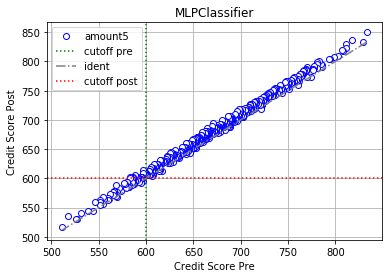

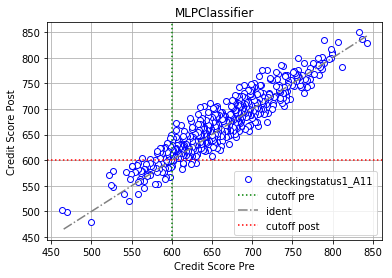

In [40]:
Z = perturb(nnet,X_train_std,predictors)
print(Z[['amount5','checkingstatus1_A11']].mean())
perturb_summary(Z,var='amount5')
plt.show()
perturb_summary(Z,var='checkingstatus1_A11')
plt.show()

## Compare Performance

In [41]:
def perf(y_est,y,delinq_reduce=0.50,revenue_loss=0.20):
    n = len(y)
    bad_total = np.sum(y)
    df = pd.DataFrame({'prob':y_est,'bad':y,'decile':pd.qcut(y_est,10)})
    display(df.groupby('decile').bad.aggregate(['mean','sum','size']))
    df = df.sort_values(by='prob')
    df['cum_bad_pct'] = df.bad.cumsum() / bad_total
    low_delinq_revenue = len(df[df.cum_bad_pct < (1 - delinq_reduce)])/n
    high_rev_delinq = df.iloc[:int(n*(1.-revenue_loss))].bad.sum() / bad_total
    
    print('Current Revenue = {:.2%}, Current Delinquency = {:.2%}'.format(1.0, bad_total/n))
    print('Max Revenue While Delinquency is Reduced by {:.2%} = {:.2%}'.format(delinq_reduce,low_delinq_revenue))
    
    print('Min Delinquency If Revenue is Reduced No More Than {:.2%} = {:.2%}'.format(
        revenue_loss,high_rev_delinq))
    return (1,bad_total/n,delinq_reduce,low_delinq_revenue,revenue_loss,high_rev_delinq)

In [42]:
print('Logistic Regression')
tmp = perf(y_pred_prob,y_test)

Logistic Regression


mean  sum  size
decile                                               
(0.00019999999999999987, 0.0639]  0.047619    2    42
(0.0639, 0.101]                   0.097561    4    41
(0.101, 0.143]                    0.195122    8    41
(0.143, 0.195]                    0.190476    8    42
(0.195, 0.252]                    0.170732    7    41
(0.252, 0.314]                    0.121951    5    41
(0.314, 0.405]                    0.333333   14    42
(0.405, 0.505]                    0.463415   19    41
(0.505, 0.635]                    0.463415   19    41
(0.635, 0.889]                    0.714286   30    42

Current Revenue = 100.00%, Current Delinquency = 28.02%
Max Revenue While Delinquency is Reduced by 50.00% = 73.91%
Min Delinquency If Revenue is Reduced No More Than 20.00% = 57.76%


In [43]:
print('Machine Learning (Random Forest)')
tmp = perf(y_pred_rf,y_test)

Machine Learning (Random Forest)


mean  sum  size
decile                             
(0.109, 0.182]  0.023810    1    42
(0.182, 0.214]  0.048780    2    41
(0.214, 0.239]  0.097561    4    41
(0.239, 0.265]  0.142857    6    42
(0.265, 0.3]    0.170732    7    41
(0.3, 0.327]    0.195122    8    41
(0.327, 0.365]  0.309524   13    42
(0.365, 0.406]  0.487805   20    41
(0.406, 0.461]  0.658537   27    41
(0.461, 0.595]  0.666667   28    42

Current Revenue = 100.00%, Current Delinquency = 28.02%
Max Revenue While Delinquency is Reduced by 50.00% = 78.50%
Min Delinquency If Revenue is Reduced No More Than 20.00% = 52.59%


In [44]:
print('Machine Learning (Gradient Boosting - Not Simple)')
tmp = perf(y_pred_grd,y_test)

Machine Learning (Gradient Boosting - Not Simple)


mean  sum  size
decile                                           
(0.06949999999999999, 0.124]  0.023810    1    42
(0.124, 0.147]                0.048780    2    41
(0.147, 0.173]                0.097561    4    41
(0.173, 0.206]                0.142857    6    42
(0.206, 0.254]                0.170732    7    41
(0.254, 0.305]                0.195122    8    41
(0.305, 0.366]                0.261905   11    42
(0.366, 0.447]                0.536585   22    41
(0.447, 0.554]                0.609756   25    41
(0.554, 0.823]                0.714286   30    42

Current Revenue = 100.00%, Current Delinquency = 28.02%
Max Revenue While Delinquency is Reduced by 50.00% = 78.74%
Min Delinquency If Revenue is Reduced No More Than 20.00% = 52.59%


In [45]:
print('Machine Learning (Neural Net)')
tmp = perf(y_pred_nnet,y_test)

Machine Learning (Neural Net)


mean  sum  size
decile                                                
(-0.00032400000000000007, 0.0151]  0.000000    0    42
(0.0151, 0.0327]                   0.024390    1    41
(0.0327, 0.0552]                   0.073171    3    41
(0.0552, 0.0848]                   0.000000    0    42
(0.0848, 0.151]                    0.048780    2    41
(0.151, 0.25]                      0.292683   12    41
(0.25, 0.384]                      0.166667    7    42
(0.384, 0.516]                     0.536585   22    41
(0.516, 0.71]                      0.707317   29    41
(0.71, 0.925]                      0.952381   40    42

Current Revenue = 100.00%, Current Delinquency = 28.02%
Max Revenue While Delinquency is Reduced by 50.00% = 85.02%
Min Delinquency If Revenue is Reduced No More Than 20.00% = 40.52%


## LIME Analysis

In [92]:
y_estimated = nnet.predict_proba(X_train_std)[:,1]
idx = np.argsort(np.argsort(y_estimated))

In [100]:
y_order = np.argsort(y_estimated)

In [93]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_std, \
        feature_names=predictors, class_names=['good','bad'], 
        discretize_continuous=True)

In [101]:
idx = y_order[0]
print('Case id: %d' % idx)
print('Probability(bad) =', nnet.predict_proba([X_train_std[idx]])[0,1])
print('True class: %s' % ['good','bad'][y_train.iloc[idx]])

Case id: 244
Probability(bad) = 0.000245074335764
True class: good


In [102]:
exp = explainer.explain_instance(X_train_std[idx], nnet.predict_proba, 
                                 num_features=10)

In [103]:
exp.show_in_notebook(show_table=True, show_all=False)

In [104]:
idx = y_order[1]
print('Case id: %d' % idx)
print('Probability(bad) =', nnet.predict_proba([X_train_std[idx]])[0,1])
print('True class: %s' % ['good','bad'][y_train.iloc[idx]])
exp = explainer.explain_instance(X_train_std[idx], nnet.predict_proba, 
                                 num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)

Case id: 126
Probability(bad) = 0.000318390884289
True class: good
